# Preliminary investigation of the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`. 
In this notebook we take a first look at this dataset.

## Imports

In [1]:
import os
import pytz
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_london = pytz.timezone("Europe/London")  # test centers are in Coventry, UK

## Data
Read in the `csv` file.

In [3]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
filename = 'sample_appointments.csv'  # appointments.csv
foldername = 'Data/UHCW'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
print("Number of records: {0}.".format(raw_data.shape[0]))
print("Column names:\n{}".format("\n".join(raw_data.columns)))

Wednesday 06 February 2019, 22:19:06
Size of data file: 291MB.
Loading data...
Number of records: 5117059.
Column names:
appointment timestamp
center age group
center id
test type
grab timestamp
CPU times: user 2.5 s, sys: 192 ms, total: 2.69 s
Wall time: 2.69 s


Work with a copy, `df`, do some preprocessing.  
**Note.** The timestamp localization and conversion may take some time on a regular computer (several minutes for 5117059 records).

In [4]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df = raw_data.copy()

Wednesday 06 February 2019, 22:19:09
CPU times: user 84.7 ms, sys: 38.8 ms, total: 123 ms
Wall time: 122 ms


In [5]:
df = df[['appointment timestamp', 'center id', 'center age group', 'test type', 'grab timestamp']]
df.columns = ['appointment', 'id', 'age group', 'test type', 'grab']

In [6]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df['appointment'] = pd.to_datetime(df['appointment'])

Wednesday 06 February 2019, 22:19:09
CPU times: user 790 ms, sys: 44.7 ms, total: 835 ms
Wall time: 831 ms


In [7]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df['appointment'] = df['appointment'].apply(lambda ts: ts.tz_localize(tz_london))

Wednesday 06 February 2019, 22:19:10
CPU times: user 2min 58s, sys: 1.97 s, total: 3min
Wall time: 2min 59s


In [8]:
df['grab'] = pd.to_datetime(df['grab'])

In [9]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df['grab'] = df['grab'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_london))

Wednesday 06 February 2019, 22:22:11
CPU times: user 1min 27s, sys: 1.06 s, total: 1min 28s
Wall time: 1min 28s


Reorder columns:

In [10]:
df = df[['id', 'test type', 'age group', 'grab', 'appointment']]

## First observations
Each row contains information about an available appointment at the time the data was collected:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5117059 entries, 0 to 5117058
Data columns (total 5 columns):
id             int64
test type      object
age group      object
grab           datetime64[ns, Europe/London]
appointment    datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2), int64(1), object(2)
memory usage: 195.2+ MB


More precisely, each row in the dataframe `df` corresponds to one appointment listed on the portal, and the 5 fields are as follows:
- `grab`: timestamp of data collection, converted to the *local timezone*, in the format "YYYY-MM-DD hh:mm:ss"
- `appointment`: timestamp of appointment, given in the *local timezone*, in the format "YYYY-MM-DD hh:mm:ss";
- `id`: the id number of the test center offering the appointment;
- `test type`: the type of test of the appointment; 
- `age group`: age group serviced for the appointment.

There are 18 test centers serving 2 age groups and delivering a total of 5 types of blood tests:

In [12]:
df[['id', 'age group', 'test type']].nunique()

id           18
age group     2
test type     5
dtype: int64

The age groups are "child" and "adult":

In [13]:
list(df['age group'].unique())

['adult', 'child']

Each test center serves only one age group but delivers up to three types of blood test:

In [14]:
df.groupby('id')['age group'].unique()

id
10136    [adult]
10137    [adult]
10138    [adult]
10188    [adult]
10207    [adult]
10243    [adult]
10244    [adult]
10250    [adult]
10254    [child]
10263    [adult]
10266    [adult]
10294    [child]
10299    [adult]
10301    [child]
10336    [child]
10341    [adult]
10352    [adult]
10449    [adult]
Name: age group, dtype: object

In [15]:
df.groupby('id')['test type'].unique()

id
10136    [Fasting Bloods, Non Fasting Bloods, INR Test]
10137                                      [Blood Test]
10138                                      [Blood Test]
10188                            [Blood Test, INR Test]
10207                                      [Blood Test]
10243                            [Blood Test, INR Test]
10244                            [Blood Test, INR Test]
10250                            [Blood Test, INR Test]
10254                                      [Blood Test]
10263                            [Blood Test, INR Test]
10266                            [Blood Test, INR Test]
10294                                      [Blood Test]
10299                          [Glucose Tolerance Test]
10301                                      [Blood Test]
10336                                      [Blood Test]
10341                                      [Blood Test]
10352                            [Blood Test, INR Test]
10449                                      [B

## Dropping the column `age group`
We will no longer be using the column `age group`:

In [16]:
df.drop('age group', axis=1, inplace=True)

## Ordering the data by test center

We can sort the test centers by the number of test types:

In [17]:
df.groupby('id')['test type'].nunique().reset_index().sort_values(
    ['test type', 'id']).rename(
    index=str, columns={'id': 'center id', 'test type': 'nb of test types'}
).reset_index(drop=True)

,center id,nb of test types
0,10137,1
1,10138,1
2,10207,1
3,10254,1
4,10294,1
5,10299,1
6,10301,1
7,10336,1
8,10341,1
9,10449,1


We can sort the centers by the number of records:

In [18]:
df.groupby('id')['test type'].count().reset_index().sort_values(
    ['test type', 'id']).rename(
    index=str, columns={'id': 'center id', 'test type': 'nb of records'}
).reset_index(drop=True)

,center id,nb of records
0,10254,25479
1,10336,32729
2,10299,34530
3,10294,40068
4,10301,49209
5,10138,118360
6,10263,157930
7,10341,179054
8,10449,212447
9,10137,249141


We can combine these two in a new dataframe:

In [19]:
grouped_cid = df.groupby('id')
df1 = grouped_cid['test type'].nunique().reset_index()
df1['count'] = grouped_cid['test type'].count().reset_index()['test type']

df1.sort_values(by=['test type', 'count']).rename(
    index=str, columns={'id': 'center id', 'test type': 'nb of test types', 'count': 'nb of records'}
).reset_index(drop=True)

,center id,nb of test types,nb of records
0,10254,1,25479
1,10336,1,32729
2,10299,1,34530
3,10294,1,40068
4,10301,1,49209
5,10138,1,118360
6,10341,1,179054
7,10449,1,212447
8,10137,1,249141
9,10207,1,380060


## Times the appointments go online

Not all appointments in the future are accessible online at all times.  In this section of the notebook we will investigate how many days the appointments are posted ahead of time.

### Remark: dealing with artefacts
This is not merely a matter of curiosity.  Indeed, when we reconstruct the booking history of the appointments in notebook `UHCW_reconstruction.ipynb`, there will be artefacts if we do not account for the fact that only a finite number of appointments are visible on the portal.  Namely, we will erroneously interpret an appointment appearing on the dataset as an appointment having been cancelled and therefore become visible again on the chart.

### Main questions

1. Do all appointments on a new day go online at the same time?
1. If so, how many days ahead, and at what time?
1. Do all test centers follow the same rule?

### Timestamps of `first appearance`
We first look at the `grab` timestamp when each `appointment` appears in `df`.  Except for the very first results, this should indicate when the `appointment` first appeared online.

More precisely, we construct the dataframe `df_post_appt`, where we record the `first appearance` timestamps of all appointments falling on the same day (and grouped by center `id` and `test type`).

In [20]:
df_post_appt = df.groupby(['id', 'test type', 'appointment'])['grab'].min().to_frame()

df_post_appt.reset_index(inplace=True)

df_post_appt['appointment date'] = df_post_appt['appointment'].apply(lambda ts: ts.date())

df_post_appt.rename(index=str, columns={'grab': 'first appearance'}, inplace=True)
df_post_appt['first appearance date'] = df_post_appt['first appearance'].apply(lambda ts: ts.date())
df_post_appt['open window'] = df_post_appt['appointment date'] - df_post_appt['first appearance date']

In [21]:
df_post_appt.head()

,id,test type,appointment,first appearance,appointment date,first appearance date,open window
0,10136,Fasting Bloods,2019-01-17 07:20:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
1,10136,Fasting Bloods,2019-01-17 07:25:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
2,10136,Fasting Bloods,2019-01-17 07:30:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
3,10136,Fasting Bloods,2019-01-17 07:35:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
4,10136,Fasting Bloods,2019-01-17 07:40:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days


We generate a column with the `appointment date` since we expect that all appointments on a new appointment date go online at the same time, and the `open window` column records the number of days the `first appearance` occurs before the `appointment date`.  

Indeed, for most appointment *dates*, there is only one first `grab` timestamp:

In [22]:
df_post_appt.drop(
    'appointment', axis=1).groupby(
    ['id', 'test type', 'appointment date'])['first appearance'].nunique().to_frame()['first appearance'].value_counts()

1    1354
2      19
3       4
4       3
8       2
9       1
5       1
Name: first appearance, dtype: int64

In fact, given the size of `df_post_appt`, there are few distinct `first appearance` timestamps:

In [23]:
df_post_appt['first appearance'].nunique()

36

Let's look at the top 5 most occurring `first appearance` timestamps:

In [24]:
df_post_appt['first appearance'].value_counts()[0:5]

2019-01-15 13:40:00+00:00    53761
2019-01-16 00:00:00+00:00      660
2019-01-15 14:50:00+00:00      288
2019-01-16 08:00:00+00:00        7
2019-01-16 09:50:00+00:00        6
Name: first appearance, dtype: int64

The most occurring timestamp corresponds to the first `grab` timestamp in the dataframe `df`:

In [25]:
df['grab'].min()

Timestamp('2019-01-15 13:40:00+0000', tz='Europe/London')

We will ignore this timestamp since it most likely is an artefact of the data collection having to start when the system is already in place.  

### Classifying centers by `first appearance` timestamps
We record the two most occurring `first appearance` timestamps:

In [26]:
new_posting_timestamp_1 = df_post_appt['first appearance'].value_counts().index[1]
new_posting_timestamp_2 = df_post_appt['first appearance'].value_counts().index[2]

Next we look at the test centers with these `first appearance` values appearing in their data:

These two timestamps split the centers into two disjoint subsets:

In [27]:
df_centers_1 = df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_1]['id'].drop_duplicates().to_frame().reset_index(drop=True)
df_centers_2 = df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_2]['id'].drop_duplicates().to_frame().reset_index(drop=True)

In [28]:
df_centers_1

,id
0,10188
1,10207
2,10243
3,10244
4,10250
5,10254
6,10263
7,10266
8,10299
9,10301


In [29]:
pd.merge(df_centers_1, df_centers_2, how='inner', on='id')

,id


The resulting dataframe is empty, showing that the two sets are disjoint.

### Appointments with most occurring `first appearance` timestamp

The next most occuring `first appearance` timestamp falls at midnight:

In [30]:
new_posting_timestamp_1

Timestamp('2019-01-16 00:00:00+0000', tz='Europe/London')

  This strongly suggests that all appointments on a new day go online at midnight a certain number of days ahead (which we will calculate later).  
  
We test this conjecture by looking at the dates of the appointments for which this is indeed the first appearance:

In [31]:
df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_1].groupby(
    ['id', 'test type'])['appointment date'].unique().to_frame()

appointment date
id    test type                                       
10188 Blood Test              [2019-01-16, 2019-03-09]
      INR Test                [2019-01-16, 2019-03-20]
10207 Blood Test                          [2019-03-20]
10243 Blood Test                          [2019-05-21]
      INR Test                            [2019-05-21]
10244 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10250 Blood Test                          [2019-04-10]
      INR Test                            [2019-04-10]
10254 Blood Test                          [2019-03-20]
10263 Blood Test                          [2019-03-11]
10266 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10299 Glucose Tolerance Test              [2019-05-21]
10301 Blood Test                          [2019-03-20]
10352 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10449 Blood Test                          [2019-04-11]

A majority of the test centers (12 out of 18) appear in this table.
If we discard the appointments with a date `2019-01-16`, occurring soon after the start of data collection, all appointments in this table with a `first appearance` timestamp of `2019-01-16 00:00:00` are on the same day (taking each test center and test type individually).

This table also shows that the different test centers choose to open their appointments with a different number of days ahead of time.  

On the other hand, again ignoring the `first appearance` date of `2019-01-16`, all test centers, except center `10188`, choose to open their appointments for all test types at the same time.  This follows directly by inspection, or programmatically with:

In [32]:
df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_1].groupby(
    ['id'])['appointment date'].unique().to_frame()

,appointment date
id,
10188,"[2019-01-16, 2019-03-09, 2019-03-20]"
10207,[2019-03-20]
10243,[2019-05-21]
10244,[2019-04-11]
10250,[2019-04-10]
10254,[2019-03-20]
10263,[2019-03-11]
10266,[2019-04-11]
10299,[2019-05-21]


Let's look at the number of days the appointments are put online ahead of time.

In [33]:
df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_1].groupby(
    ['id', 'test type'])['open window'].unique().to_frame()['open window'].apply(
    lambda ow: ow[-1]).to_frame()

open window
id    test type                         
10188 Blood Test                 52 days
      INR Test                   63 days
10207 Blood Test                 63 days
10243 Blood Test                125 days
      INR Test                  125 days
10244 Blood Test                 85 days
      INR Test                   85 days
10250 Blood Test                 84 days
      INR Test                   84 days
10254 Blood Test                 63 days
10263 Blood Test                 54 days
10266 Blood Test                 85 days
      INR Test                   85 days
10299 Glucose Tolerance Test    125 days
10301 Blood Test                 63 days
10352 Blood Test                 85 days
      INR Test                   85 days
10449 Blood Test                 85 days

### Appointments with next most occurring `first appearance` timestamp
We now perform the same analysis for the next most occurring `first appearance` timestamp:

In [34]:
new_posting_timestamp_2

Timestamp('2019-01-15 14:50:00+0000', tz='Europe/London')

The time of `14:50` is quite unusual.
Remember that the data was collected at discrete times:

In [35]:
df['grab'].unique()[6:9]

array([Timestamp('2019-01-15 14:40:00+0000', tz='Europe/London'),
       Timestamp('2019-01-15 14:50:00+0000', tz='Europe/London'),
       Timestamp('2019-01-15 15:00:00+0000', tz='Europe/London')],
      dtype=object)

Thus, the corresponding appointments have been posted any time between `14:40` and `14:50`.

As earlier, let's look at the appointment dates for which `new_posting_timestamp_2` is the `first appearance` timestamp:

In [36]:
df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_2].groupby(
    ['id', 'test type'])['appointment date'].unique().to_frame()

appointment date
id    test type                                   
10136 Fasting Bloods                  [2019-03-20]
      INR Test            [2019-01-16, 2019-04-04]
      Non Fasting Bloods  [2019-01-16, 2019-03-20]
10137 Blood Test                      [2019-05-03]
10138 Blood Test                      [2019-03-21]
10294 Blood Test                      [2019-03-20]
10341 Blood Test                      [2019-05-02]

We see that 5 out of remaining 6 test centers appear in this table.
Similar conclusions hold: ignoring the date of `2019-01-16`, for any given test center and test type, all appointments with a `first appearance` timestamp of `2019-01-15 14:50:00` occur on the same day.

Let's look at the number of days the appointments are put online ahead of time:

In [37]:
df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_2].groupby(
    ['id', 'test type'])['open window'].unique().to_frame()['open window'].apply(
    lambda ow: ow[-1]).to_frame()

open window
id    test type                     
10136 Fasting Bloods         64 days
      INR Test               79 days
      Non Fasting Bloods     64 days
10137 Blood Test            108 days
10138 Blood Test             65 days
10294 Blood Test             64 days
10341 Blood Test            107 days

### The remaining test center
Let's now find the remaining center:

In [38]:
all_centers = set(df['id'].values)
centers_1 = set(df_centers_1['id'])
centers_2 = set(df_centers_2['id'])
remaining_center = list(all_centers.difference(centers_1.union(centers_2)))[0]
remaining_center

10336

Let's look at its data.  We already know that it delivers one test type:

In [39]:
list(df[df['id'] == remaining_center]['test type'].unique())

['Blood Test']

Save it in a separate dataframe, for convenience:

In [40]:
df0 = df.loc[df['id'] == remaining_center, ['grab', 'appointment']].reset_index(drop=True)

We follow the procedure we used earlier for the entire dataframe `df`.
That is, we construct the dataframe `df0_post_appt`, where we record the `first appearance` timestamps of all appointments falling on the same day:

In [41]:
df0_post_appt = df0.groupby(['appointment'])['grab'].min().to_frame()

df0_post_appt.reset_index(inplace=True)

df0_post_appt['appointment date'] = df0_post_appt['appointment'].apply(lambda ts: ts.date())
df0_post_appt.rename(index=str, columns={'grab': 'first appearance'}, inplace=True)

In [42]:
df0_post_appt.head()

,appointment,first appearance,appointment date
0,2019-01-16 08:15:00+00:00,2019-01-15 13:40:00+00:00,2019-01-16
1,2019-01-16 13:00:00+00:00,2019-01-15 13:40:00+00:00,2019-01-16
2,2019-01-17 08:15:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17
3,2019-01-17 08:30:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17
4,2019-01-17 10:00:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17


For this center, *all* appointments appeared in `df` at the same time:

In [43]:
set(df0_post_appt['first appearance'])

{Timestamp('2019-01-15 13:40:00+0000', tz='Europe/London')}

# Visualization of last bookings

To finish this preliminary investigation of the dataset, we plot the *last* booking of the appointments for test center `10254`, which delivers only one type of blood test.

In [44]:
cid = 10254
df0 = df.loc[df['id'] == cid, ['appointment', 'grab']]
df0.reset_index(drop=True, inplace=True)

In [45]:
last_grab = df0['grab'].max()

In [46]:
df0_last_booking = pd.DataFrame()
df0_last_booking['last booking'] = df0.groupby('appointment')['grab'].max()

df0_last_booking.drop(df0_last_booking[df0_last_booking['last booking'] == last_grab].index, inplace=True)
df0_last_booking.reset_index(inplace=True)

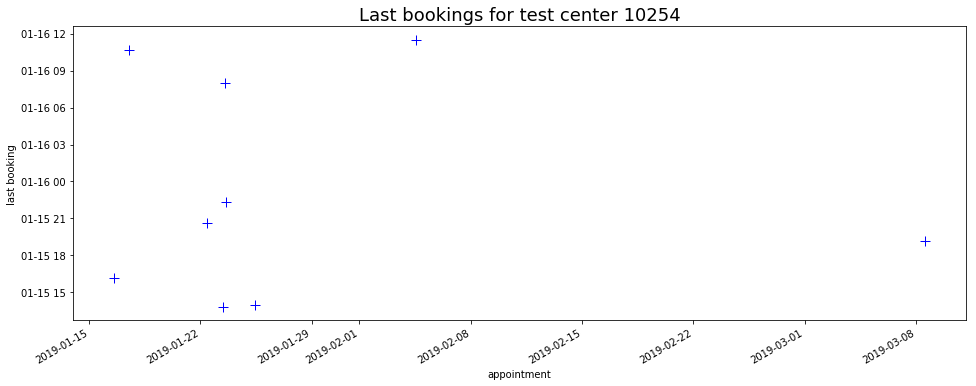

In [47]:
ax = df0_last_booking.plot(x='appointment', y='last booking', figsize=(16, 6), style='+', **{"markersize": 10, 'markeredgecolor': 'b'});
ax.set_xlabel("appointment");
ax.set_ylabel("last booking");
ax.get_legend().remove()
ax.set_title("Last bookings for test center {}".format(cid), fontsize=18);

This is far from satisfactory, though.  Booked appointments can be cancelled, thus resurfacing in the dataset, and rebooked again, thus disappearing again, and all this history is not visible in the above plot.
We will need more sophisticated processing to reconstruct the exact booking history of all appointments.
This we will do in the separate notebook `UHCW_reconstruction.ipynb`.